 # **Income Prediction**

In [113]:



from subprocess import check_output



import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from scipy.stats import pointbiserialr, spearmanr
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, roc_auc_score


import statsmodels.api as sm


from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import numpy as np 
import pandas as pd

 # **Let's get started**

## The training dataset

Let's **clean** this dataset by finding the rows with missing values

In [93]:
x=open('train.csv','r')
m=x.readlines()
row_incomplete=[]
for i  in range(len(m)):
    if ',,' in m[i]:
        row_incomplete.append(i)
for i in range(len(m)):
    if i not in row_incomplete :
        k=m[i].split(',')
        if k[-1]=='\n':
         row_incomplete.append(i)

    


Cleaned the dataset by elimnating all the blank values

storing the cleaned data in a new CSV file

In [96]:
x_2=open('train_2.csv','w')

for i in range(len(m)):
    if i not in row_incomplete:
        k=m[i].split(',')
        
        x_2.write('{},{},{},{},{},{},{},{},{},{},{},{},{},{}'.format(k[1],k[2],k[3],k[4],k[5],k[6],k[7],k[8],k[9],k[10],k[11],k[12],k[13],k[14]))




 # **Exploring the  cleaned data**

In [97]:
cols= list(pd.read_csv("train_2.csv",nrows=1))
training_data = pd.read_csv("train_2.csv",usecols =[i for i in cols if i != 'Unnamed: 0'])
training_data.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country
0,67,Private,366425,Doctorate,16,Divorced,Exec-managerial,Not-in-family,White,Male,99999,0,60,United-States
1,17,Private,244602,12th,8,Never-married,Other-service,Own-child,White,Male,0,0,15,United-States
2,31,Private,174201,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States
3,58,State-gov,110199,7th-8th,4,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States
4,25,State-gov,149248,Some-college,10,Never-married,Other-service,Not-in-family,Black,Male,0,0,40,United-States


# Let's also have a look at the seperate file containing the class labels

We will first also clean this file to remove all the class labels for the instances which have been removed from the data containing the training instances

In [119]:
x=open('train_class_labels.csv','r')
m=x.readlines()

x_2=open('train_class_labels_2.csv','w')

for i in range(len(m)):
    if i not in row_incomplete:
        k=m[i].split(',')
        
        x_2.write('{}'.format(k[1]))

cols= list(pd.read_csv("train_class_labels_2.csv",nrows=1))
training_labels = pd.read_csv("train_class_labels_2.csv")
training_labels.head()





,income_>50K
0,1
1,0
2,1
3,0
4,0


In [120]:
training_labels.shape

(40727, 1)

The class label for all these training instances is stored in a seperate file called train_class_labels.csv

In [ ]:
training_data = training_data[training_data["workclass"]  in ['Private','Self-emp-not-inc', 'Local-gov', 'State-gov','Self-emp-inc','Federal-gov', 'Without-pay','Never-worked']]
training_data = training_data[training_data["occupation"] in ['Craft-repair','Prof-specialty','Exec-managerial','Adm-clerical','Sales','Other-service','Machine-op-inspct','Transport-moving','Handlers-cleaners','Farming-fishing','Tech-support','Protective-serv','Priv-house-serv','Armed-Forces']]
training_data = training_data[training_data["native-country"] in ['United-States', 'Germany', 'Ecuador', 'Mexico','Philippines' ,'Puerto_Rico' ,'Canada' ,'El-Salvador', 'India' ,'Cuba' ,'China' ,'England' ,'South', 'Dominican-Republic', 'Jamaica','Italy' ,'Japan' ,'Guatemala' ,'Vietnam' ,'Columbia' ,'Poland' ,'Haiti' ,'Portugal' ,'Taiwan', 'Iran' ,'Nicaragua', 'Ecuador', 'Peru' ,'France' ,'Ireland' ,'Thailand' ,'Hong' ,'Cambodia' ,'Trinidad&Tobago' ,'Honduras' ,'Outlying-US(Guam-USVI-etc)', 'Scotland' ,'Yugoslavia' ,'Laos' ,'Hungary' ,'Holand-Netherlands']]



Let's find the number of instances in the training dataset

In [115]:
training_data.shape

(40727, 14)

There are 40728 training instances in the dataset

Let us explore the statistics for individual fields .i.e. features of the training instance

In [116]:
training_data.describe()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country
count,40727.000000,40727.000000,4.072700e+04,40727.000000,40727.000000,40727.000000,40727.000000,40727.000000,40727.000000,40727.000000,40727.000000,40727.000000,40727.000000,40727.000000
mean,38.521251,2.201488,1.897859e+05,10.307290,10.113512,0.521153,5.973261,1.412626,3.678665,0.674982,1118.639944,89.243450,40.908464,36.394407
std,13.243211,0.954221,1.059021e+05,3.823184,2.557084,0.499558,4.023729,1.597114,0.834301,0.468387,7639.841297,406.568894,12.014493,6.081163
min,17.000000,0.000000,1.349200e+04,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,28.000000,2.000000,1.173630e+05,9.000000,9.000000,0.000000,2.000000,0.000000,4.000000,0.000000,0.000000,0.000000,40.000000,38.000000
50%,37.000000,2.000000,1.782820e+05,11.000000,10.000000,1.000000,6.000000,1.000000,4.000000,1.000000,0.000000,0.000000,40.000000,38.000000
75%,47.000000,2.000000,2.381530e+05,12.000000,13.000000,1.000000,9.000000,3.000000,4.000000,1.000000,0.000000,0.000000,45.000000,38.000000
max,90.000000,6.000000,1.490400e+06,15.000000,16.000000,1.000000,13.000000,5.000000,4.000000,1.000000,99999.000000,4356.000000,99.000000,40.000000


Note that sampling weight i.e. fnlwgt is not related to income and hence it will be not be taken as a valid feature.

 # Exploring the categorical fields. 

In [110]:

category_col=['workclass','marital-status', 'occupation', 'relationship', 'race', 'gender','education','native-country']
l=[]
for i in category_col:
    print(i)
    print((training_data[i].value_counts()))



workclass
2    30057
4     3404
1     2792
5     1721
3     1471
0     1262
6       20
Name: workclass, dtype: int64
marital-status
1    21225
0    19502
Name: marital-status, dtype: int64
occupation
2     5433
3     5415
9     5380
0     4944
11    4877
7     4348
6     2663
13    2085
5     1854
4     1338
12    1296
10     867
8      215
1       12
Name: occupation, dtype: int64
relationship
0    16815
1    10528
3     5978
4     4303
5     1884
2     1219
Name: relationship, dtype: int64
race
4    35007
2     3817
1     1184
0      394
3      325
Name: race, dtype: int64
gender
1    27490
0    13237
Name: gender, dtype: int64
education
11    13311
15     8908
9      6811
12     2267
8      1740
1      1481
7      1360
0      1098
5       740
14      706
6       615
2       520
10      489
4       413
3       202
13       66
Name: education, dtype: int64
native-country
38    37168
25      838
29      261
10      176
32      159
1       139
7       137
18      130
4       120
2      

# Plot for the work-class field

In [ ]:
dict_work={'Private'    :         30044,
'Self-emp-not-inc'  :  3404,
'Local-gov'        :    2792,
'State-gov'      :      1721,
'Self-emp-inc'    :     1471,
'Federal-gov'     :     1262,
'Without-pay'    :     20}

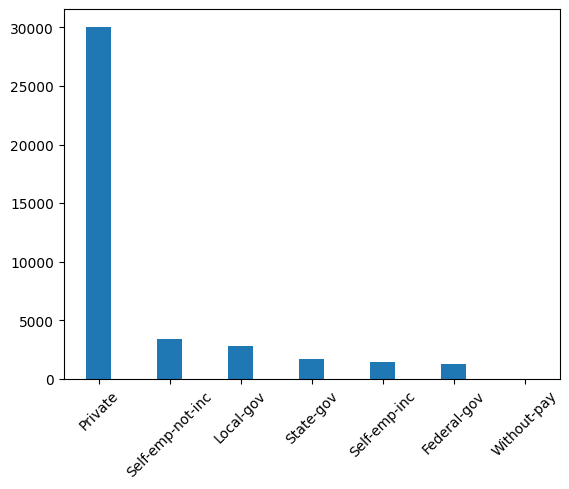

In [ ]:
import matplotlib.pyplot as plt
x=np.arange(len(dict_work))
width=0.35
data = {'milk': 60, 'water': 10}
names = list(dict_work.keys())
values = list(dict_work.values())
fig, ax = plt.subplots()
rects1 = ax.bar(x , list(dict_work.values()), width,)

ax.set_xticks(x,list(dict_work.keys()),rotation=45)


# Plot for the  Marital Status Feature

In [99]:
dict_marital={'Married-civ-spouse' :      18972,
'Never-married'     :       13150,
'Divorced'       :          5664,
'Separated'       :          1252,
'Widowed'         :          1150,
'Married-spouse-absent'  :    500,
'Married-AF-spouse'     :      26}

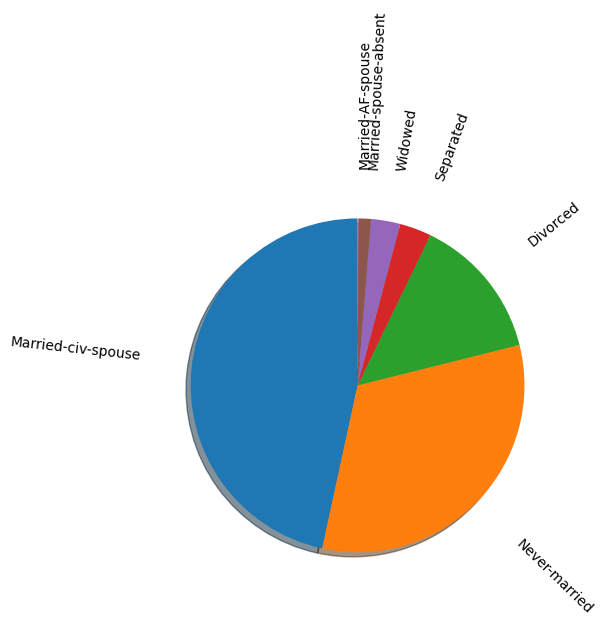

In [111]:
import matplotlib.pyplot as plt

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Frogs', 'Hogs', 'Dogs', 'Logs'
sizes = [15, 30, 45, 10]
explode = (0, 0, 0, 0,0,0,0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(dict_marital.values(), explode=explode, labels=dict_marital.keys(),
        shadow=True, startangle=90,rotatelabels= True,normalize=True,pctdistance=1,center=(0,0),labeldistance=1.3)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

# **Plot for the nationality feature**

In [100]:

dic_nation={'Mexico'       :                  838,
'Philippines'    :                 261,
'Germany  '       :                176,
'Puerto-Rico '    :                159,
'Canada  '         :               139,
'El-Salvador'      :               137,
'India'           :               130,
'Cuba'            :                120,
'China'           :               106,
'England'          :              102,
'Jamaica'         :                94,
'South'            :               91,
'Dominican-Republic':               91,
'Italy'             :          89,
'Japan'             :               81,
'Guatemala'         :              77,
'Vietnam'           :              75,
'Columbia'          :               72,
'Poland'            :              66,
'Haiti'             :              65,
'Portugal'          :              55,
'Iran'              :             50,
'Taiwan'            :              49,
'Nicaragua'          :              45,
'Greece'             :             44,
'Ecuador'             :             40,
'Peru'                :            39,
'Ireland'             :             31,
'France'              :             30,
'Thailand'             :            28,
'Hong'                 :            27,
'Cambodia'              :           22,
'Trinadad&Tobago'       :           21,
'Honduras'              :           19,
'Scotland'              :          18}


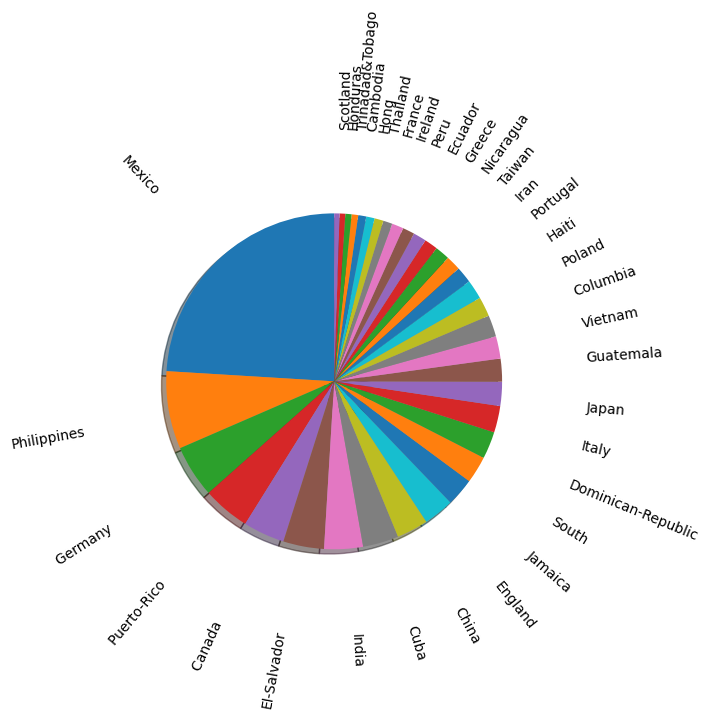

In [103]:
import matplotlib.pyplot as plt

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Frogs', 'Hogs', 'Dogs', 'Logs'
sizes = [15, 30, 45, 10]
  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(dic_nation.values(), labels=dic_nation.keys(),
        shadow=True, startangle=90,rotatelabels= True,normalize=True,pctdistance=1,center=(0,0),labeldistance=1.5)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

The majority of instances are from United States i.e. around 39,000 instaances. That share is not displayed in the pie chart because it would undermine the display of those nations which have a smaller share.

# Converting Categorical Columns into Numerical Values

This is necessary for feeding data to the prediction model.
Firstly  we shall  apply discretisation on the Column Marital Status 
.This is necessary to remove Noise from the Data

In [104]:
training_data.replace(['Divorced', 'Married-AF-spouse', 
              'Married-civ-spouse', 'Married-spouse-absent', 
              'Never-married','Separated','Widowed'],
             ['not married','married','married','married',
              'not married','not married','not married'], inplace = True)

Now let's convert categorical columns to numerical representations

In [109]:
for col in category_col:
    l, m = np.unique(training_data[col], return_inverse=True) 
    training_data[col] = m


training_data.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country
0,67,2,366425,10,16,1,3,1,4,1,99999,0,60,38
1,17,2,244602,2,8,1,7,3,4,1,0,0,15,38
2,31,2,174201,9,13,0,3,0,4,1,0,0,40,38
3,58,5,110199,5,4,0,13,0,4,1,0,0,40,38
4,25,5,149248,15,10,1,7,1,2,1,0,0,40,38


# Feature Selection

In [130]:
col_names = training_data.columns

param=[]
correlation=[]
abs_corr=[]

for c in col_names:
    
    
        if len(training_data[c].unique()) <= 2:
            corr = spearmanr(training_labels['income_>50K'],training_data[c])[0]
        else:
            corr = pointbiserialr(training_labels['income_>50K'],training_data[c])[0]
        param.append(c)
        correlation.append(corr)
        abs_corr.append(abs(corr))

#Create dataframe for visualization
param_df=pd.DataFrame({'correlation':correlation,'parameter':param, 'abs_corr':abs_corr})

#Sort by absolute correlation
param_df=param_df.sort_values(by=['abs_corr'], ascending=False)

#Set parameter name as index
param_df=param_df.set_index('parameter')

param_df

,correlation,abs_corr
parameter,,
marital-status,-0.437113,0.437113
educational-num,0.334432,0.334432
relationship,-0.253480,0.253480
age,0.237597,0.237597
hours-per-week,0.227918,0.227918
capital-gain,0.221671,0.221671
gender,0.215658,0.215658
capital-loss,0.145513,0.145513
education,0.079821,0.079821


In [131]:
len(param_df)

14

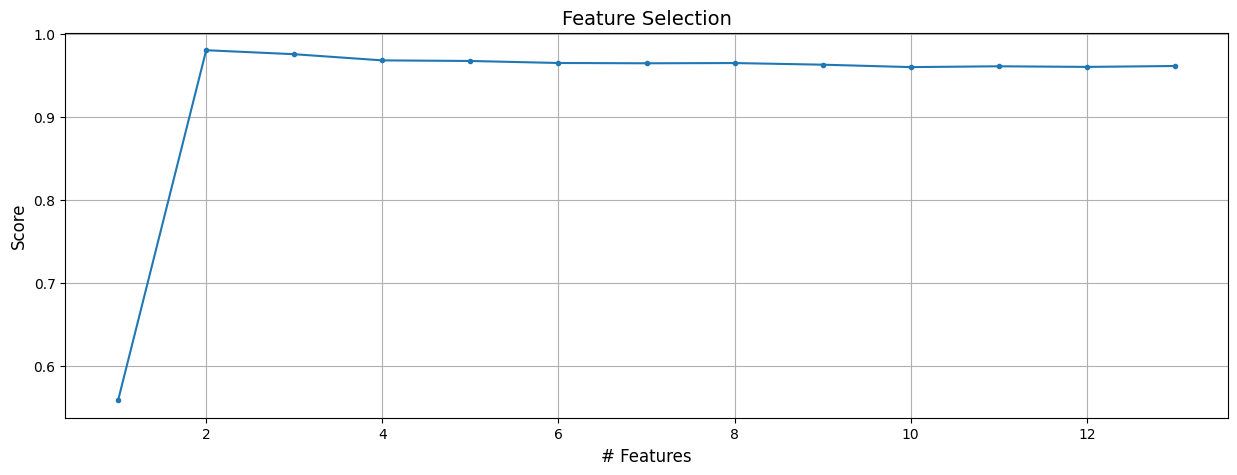

In [144]:
scoresCV = []
scores = []

for i in range(1,len(param_df)):
    new_df=training_data[param_df.index[0:i+1].values]
    X = new_df.iloc[:,1::]
    y = new_df.iloc[:,0]
    clf = DecisionTreeClassifier()
    scoreCV = cross_val_score(clf, X, y, cv= 10)
    scores.append(np.mean(scoreCV))
    
plt.figure(figsize=(15,5))
plt.plot(range(1,len(scores)+1),scores, '.-')
plt.axis("tight")
plt.title('Feature Selection', fontsize=14)
plt.xlabel('# Features', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.grid();

In [145]:
best_features=param_df.index[0:4].values
print('Best features:\t',best_features)

Best features:	 ['marital-status' 'educational-num' 'relationship' 'age']


 # Best features:	['marital-status' 'educational-num' 'relationship' 'age']

 We will classify data points on the bases of these features only

Storing the Trained Data into a CSV file.

In [149]:
training_data.to_csv('data_for_prediction.csv')

Storing Training Instances as well as the labels into two different arrays

In [152]:
x=open('train_class_labels_2.csv','r')
n=x.readlines()
x_2=open('data_for_prediction.csv','r')
n_2=x_2.readlines()
training_array = []
label_array=[]
for i in range(1,len(n)):
    label_array.append(int(n[i]))

for i in range(1,len(n_2)):
    k=n_2[i].split(',')
    training_array.append([int(k[1]),int(k[5]),int(k[6]),int(k[8])])
    

    



In [167]:
label_array

[1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,


# **Prediction**

 # **Running Support Vector Machines**

In [157]:
clf=SVC()
clf.fit(training_array, label_array)


SVC()

# Classifying the  test Data 

Note that the instances for the test data are stored in the file test.csv

In [177]:
x=open('test.csv','r')
m=x.readlines()

row_incomplete=[]
for i  in range(len(m)):
    if ',,' in m[i]:
        row_incomplete.append(i)

for i in range(len(m)):
    if i not in row_incomplete :
        k=m[i].split(',')
        if k[-1]=='\n':
         row_incomplete.append(i)


x_2=open('test_2.csv','w')

for i in range(len(m)):
    if i not in row_incomplete:
        k=m[i].split(',')
        
        x_2.write('{},{},{},{},{},{},{},{},{},{},{},{},{},{}'.format(k[0],k[1],k[2],k[3],k[4],k[5],k[6],k[7],k[8],k[9],k[10],k[11],k[12],k[13]))

        
test_data=pd.read_csv('test_2.csv')

for col in category_col:
    l, m = np.unique(test_data[col], return_inverse=True) 
    test_data[col] = m


test_data.head()



    




,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country
0,39,4,327120,11,9,2,2,0,4,1,0,0,40,22
1,32,2,123253,7,12,2,2,0,4,1,0,0,42,28
2,47,2,232628,11,9,2,2,0,2,1,0,0,40,28
3,19,2,374262,2,8,4,5,3,4,1,0,0,20,28
4,46,4,311231,11,9,2,4,0,4,1,0,0,40,28


In [178]:
test_data.to_csv('test_data_for_prediction.csv')

In [185]:

x_2=open('test_data_for_prediction.csv','r')
n_2=x_2.readlines()
test_array = []
test_label_array=[]


for i in range(1,len(n_2)):
    k=n_2[i].split(',')
    test_array.append([int(k[1]),int(k[5]),int(k[6]),int(k[8])])
    

f=clf.predict(test_array)



The array showing the Class labels for the test datasets

In [186]:
f

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

# K Nearest Neighbours

In [181]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(training_array, y)

KNeighborsClassifier(n_neighbors=3)

# Classifying the test data

The array displayed below showcases the results for the test Dataset using the K-Nearest neighburs classifier

In [187]:
neigh.predict(test_array)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,